<a href="https://colab.research.google.com/github/Prim9000/Thai_TTS/blob/add-license-1/thaitts_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
import os
from os.path import exists, join, basename, splitext
git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 9168aea
  !pip install -q librosa unidecode
  
import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

TensorFlow 1.x selected.
Previous HEAD position was 5bc2a53 README.md: reporting correct number after finding bug in inference time code
HEAD is now at 9168aea README.md: layout
     |████████████████████████████████| 245kB 15.7MB/s 


In [2]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

tacotron2_pretrained_model = 'tacotron2_statedict.pt'
if not exists(tacotron2_pretrained_model):
  # download the Tacotron2 pretrained model
  download_from_google_drive('1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA', tacotron2_pretrained_model)
waveglow_pretrained_model = 'waveglow_old.pt'
if not exists(waveglow_pretrained_model):
  # download the Waveglow pretrained model  
  download_from_google_drive('1WsibBTsuRg_SF2Z6L6NFRTT-NjEy1oTx', waveglow_pretrained_model)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    985      0 --:--:-- --:--:-- --:--:--   987
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  107M    0  107M    0     0  39.0M      0 --:--:--  0:00:02 --:--:-- 92.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1478      0 --:--:-- --:--:-- --:--:--  1472
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  644M    0  644M    0     0  93.9M      0 --:--:--  0:00:06 --:--:--  124M


In [3]:
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='viridis')

torch.set_grad_enabled(False)
        
# initialize Tacotron2 with the pretrained model
hparams = create_hparams()
hparams.sampling_rate = 22050
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval()#.half()

# initialize Waveglow with the pretrained model
# waveglow = torch.load(waveglow_pretrained_model)['model']
# WORKAROUND for: https://github.com/NVIDIA/tacotron2/issues/182
import json
from glow import WaveGlow
waveglow_config = json.load(open('%s/waveglow/config.json' % project_name))['waveglow_config']
waveglow = WaveGlow(**waveglow_config)
waveglow.load_state_dict(torch.load(waveglow_pretrained_model)['model'].state_dict())
_ = waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



tacotron2/waveglow/glow.py:74: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1940.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList'

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

In [5]:
%cd /content/tacotron2

/content/tacotron2


In [6]:
!pip uninstall --yes protobuf

Uninstalling protobuf-3.12.4:
  Successfully uninstalled protobuf-3.12.4


In [7]:
!pip install --no-binary=protobuf protobuf

     |████████████████████████████████| 235kB 15.2MB/s 
Skipping wheel build for protobuf, due to binaries being disabled for it.
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.4.0 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
    Running setup.py install for protobuf ... done


In [8]:
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [9]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [10]:
hparams = create_hparams()
hparams.sampling_rate = 22050

Here is the weight : https://drive.google.com/file/d/1tukxLX1Ul2O3zpTztX18K6WWfMrPiXJ2/view?usp=sharing

In [11]:
!gdown --id 1tukxLX1Ul2O3zpTztX18K6WWfMrPiXJ2

Downloading...
From: https://drive.google.com/uc?id=1tukxLX1Ul2O3zpTztX18K6WWfMrPiXJ2
To: /content/tacotron2/checkpoint_10000
338MB [00:05, 60.7MB/s]


In [12]:
checkpoint_path = "/content/tacotron2/checkpoint_10000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [13]:
waveglow_path = '/content/waveglow_old.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

# Synthesizing the text 

In [22]:
text = 'มะลิ้งกิ๊งก๊องสามารองก๊องแก๊งป๊ะริ๊งปิ๊งป๊องเมี้ยงปร๊ะเมี้ยง'

In [15]:
!pip install pythainlp

     |████████████████████████████████| 11.0MB 14.1MB/s 
     |████████████████████████████████| 747kB 56.9MB/s 


In [23]:
from pythainlp import word_tokenize
token_text2 = word_tokenize(text)
token_text = ''
for word in token_text2 :
  token_text += word
  token_text += " "
token_text += ' .'

In [24]:
sequence = np.array(text_to_sequence(token_text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

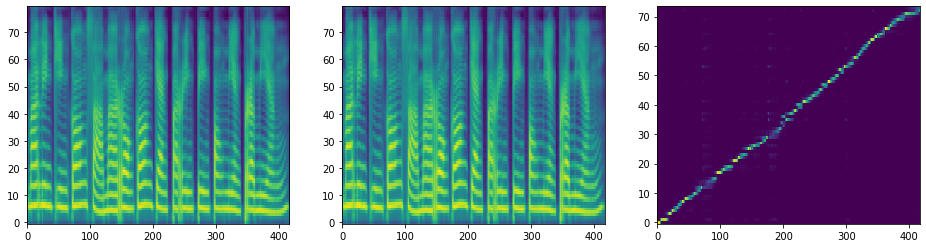

In [25]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
%matplotlib inline
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))
plt.show()

In [26]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [27]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)